# Musical genre handling

In [34]:
import pandas as pd
import numpy as np
import mpld3
import re
import math
import operator
import matplotlib.pyplot as plt
from datetime import datetime

import seaborn as sns
sns.set()

#### Definition of useful functions

In [4]:
#https://stackoverflow.com/questions/12680754/split-explode-pandas-dataframe-string-entry-to-separate-rows
def tidy_split(df, column, sep='|', keep=False):
    """
    Split the values of a column and expand so the new DataFrame has one split
    value per row. Filters rows where the column is missing.

    Params
    ------
    df : pandas.DataFrame
        dataframe with the column to split and expand
    column : str
        the column to split and expand
    sep : str
        the string used to split the column's values
    keep : bool
        whether to retain the presplit value as it's own row

    Returns
    -------
    pandas.DataFrame
        Returns a dataframe with the same columns as `df`.
    """
    indexes = list()
    new_values = list()
    df = df.dropna(subset=[column])
    for i, presplit in enumerate(df[column].astype(str)):
        values = presplit.split(sep)
        if keep and len(values) > 1:
            indexes.append(i)
            new_values.append(presplit)
        for value in values:
            indexes.append(i)
            value = re.sub("[\[\]\']", '', value)
            new_values.append(value)
    new_df = df.iloc[indexes, :].copy()
    new_df[column] = new_values
    return new_df

## Work on musical genres

### Prepare dataset: tidy split musical genres

In [28]:
#open main corups
dataset = pd.read_json("json/corpus.json")
dataset = dataset.reset_index().drop(columns = ['index'])

In [29]:
dataset.head()

,track_id,title_billboard,artist_billboard,title_spotify,artist_spotify,key,time_signature,mode,tempo,loudness,duration_ms,energy,valence,genre_list,weeks_list,ranks_list,highest_rank
0,5ayybTSXNwcarDtxQKqvWX,Poor Little Fool,Ricky Nelson,Poor Little Fool - Remastered,Ricky Nelson,0,4,1,154.999,-11.573,153933,0.332,0.795,"[adult standards, brill building pop, bubblegu...",[1958-08-08],[1],1
1,205EtD8tQnHDXMkmtYiaHF,Patricia,Perez Prado And His Orchestra,Patricia,Pérez Prado,1,4,1,137.396,-9.522,140867,0.638,0.837,"[bolero, cuban rumba, latin jazz, lounge, mamb...",[1958-08-08],[3],3
2,1TRBNskaco4d6OQ9uVY7rz,Ginger Bread,Frankie Avalon,Ginger Bread,Frankie Avalon,8,4,1,147.226,-12.136,123653,0.623,0.976,"[adult standards, brill building pop, christma...",[1958-08-08],[15],15
3,6fb0Yo4q22mmf0XCkIh2dO,Susie Darlin',Robin Luke,Susie Darlin' - Re-Recording,Robin Luke,9,4,1,123.094,-13.681,153920,0.325,0.816,[],[1958-08-08],[42],42
4,0dc0eU5THc1uE0Q0KV73XN,"Please Help Me, I'm Falling",Hank Locklin,"Please Help Me, I'm Falling",Hank Locklin,7,4,1,105.479,-10.712,141467,0.336,0.553,"[country gospel, cowboy western, nashville sou...","[1960-05-22, 1960-06-01, 1960-06-08, 1960-06-1...","[77, , 42, , 38, , 34, , 24, , 16, ...",


In [30]:
len(dataset)

19098

In [32]:
genre = dataset.copy()
#count the total number of weeks the song remains on the chart
for i, row in genre.iterrows():
    genre.loc[i,'weeks_on_chart'] = len(row['ranks_list'])

In [8]:
#split the different possible genres given for each song into unique rows
genre = tidy_split(genre,'genre_list', sep=',')

### Basic statistics

In [9]:
genre_rank = genre.groupby(['genre_list']).count()
print("----Total number of different genres : "+ str(len(genre_rank)))

----Total number of different genres : 987


In [10]:
genre_rank = genre_rank.sort_values(['title_spotify'],ascending=False)
genre_mains = genre_rank[genre_rank['weeks_list']>1]
genre_mains = genre_mains.reset_index()
genre_mains = genre_mains.loc[(genre_mains['genre_list'] != 'nan') & (genre_mains['genre_list'] != '')]
genre_mains_list = genre_mains["genre_list"].tolist()
genre_to_plot = genre[genre['genre_list'].isin(genre_mains_list)]

Musical genres rank

In [11]:
genre_mains.head(10)

,genre_list,track_id,title_billboard,artist_billboard,title_spotify,artist_spotify,key,time_signature,mode,tempo,loudness,duration_ms,energy,valence,weeks_list,ranks_list,highest_rank,weeks_on_chart
0,adult standards,3695,3695,3695,3695,3695,3695,3695,3695,3695,3695,3695,3695,3695,3695,3695,3695,3695
1,mellow gold,3635,3635,3635,3635,3635,3635,3635,3635,3635,3635,3635,3635,3635,3635,3635,3635,3635
2,soft rock,3287,3287,3287,3287,3287,3287,3287,3287,3287,3287,3287,3287,3287,3287,3287,3287,3287
3,folk rock,2978,2978,2978,2978,2978,2978,2978,2978,2978,2978,2978,2978,2978,2978,2978,2978,2978
5,christmas,2914,2914,2914,2914,2914,2914,2914,2914,2914,2914,2914,2914,2914,2914,2914,2914,2914
6,rock,2863,2863,2863,2863,2863,2863,2863,2863,2863,2863,2863,2863,2863,2863,2863,2863,2863
7,soul,2461,2461,2461,2461,2461,2461,2461,2461,2461,2461,2461,2461,2461,2461,2461,2461,2461
8,motown,2452,2452,2452,2452,2452,2452,2452,2452,2452,2452,2452,2452,2452,2452,2452,2452,2452
9,brill building pop,2287,2287,2287,2287,2287,2287,2287,2287,2287,2287,2287,2287,2287,2287,2287,2287,2287
10,classic rock,2065,2065,2065,2065,2065,2065,2065,2065,2065,2065,2065,2065,2065,2065,2065,2065,2065


Ploting all existing genres (before main classifications)

In [300]:
array = []
for i, row in genre_to_plot.iterrows():
    array.append(datetime.strptime(row['weeks_list'][0], '%Y-%m-%d').year)
genre_to_plot['year'] = array

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [301]:
genre_to_plot = genre_to_plot.sort_values(['year', 'genre_list'],ascending=True)

In [302]:
import plotly.plotly as py
import plotly.graph_objs as go

import plotly
import plotly.graph_objs as go


# Create a trace
trace = go.Scatter(
    x = genre_to_plot[:]['year'],
    y = genre_to_plot[:]['genre_list'],
    mode = 'markers'
)


data = [trace]

# Plot and embed in ipython notebook!
#py.iplot(data, filename='basic-scatter')
#plot_url = py.plot(data, filename='basic-line')
plotly.offline.plot({
    "data": data,
    "layout": go.Layout(title="Music genre")
}, auto_open=True)

'file:///Users/bernasconi/Documents/EPFL/Digital Musicology/digital_musicology/temp-plot.html'

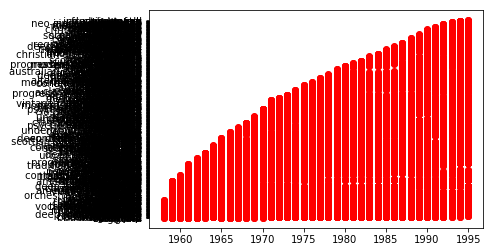

In [303]:
plt.plot(genre_to_plot[:]['year'], genre_to_plot[:]['genre_list'], 'ro')

plt.show()

### First attempt of genres categorisation

This first attempt was done for milestone 2. However it was not successful as it requires to determine and write the categorisation by hand. The second part of this notebook include a genre categorisation made from external sources retrieved with the help of the genre_scrapper.ipynb notebook.

In [345]:
main_genres = {
    "pop": ['pop', 'merseybeat'],
    "rock": ['rock'],
    "country": ['country', 'cowboy western', 'nashville sound'],
    "reggae": ['reggae'],
    "electro": ['electro'],
    "disco": ['disco','funk'],
    "soul": ['soul'],
    "r&b": ['r&b', 'urban contemporary'],
    "metal": ['metal', 'hard rock', 'psychedelic rock', 'grunge'],
    "blues": ['blues', 'doo-wop'],
    "jazz": ['jazz'],
    "folk": ['folk'],
    "christmas": ['christmas'],
    "adult standards": ['adult standards'],
    "hiphop": ['hip hop']
}
#blues, classical, country, disco, hiphop, jazz, reggae, rock, metal and pop

In [309]:
genre_to_plot.groupby(['year','genre_list']).count()

track_id  title_billboard  artist_billboard  \
year genre_list                                                           
1958  ballroom                     1                1                 1   
      big band                     1                1                 1   
      bluegrass                    3                3                 3   
      blues-rock                   1                1                 1   
      bolero                       2                2                 2   
      brill building pop          30               30                30   
      bubblegum pop                7                7                 7   
      canadian pop                 1                1                 1   
      chicago blues                1                1                 1   
      christmas                   42               42                42   
      classic girl group           1                1                 1   
      classic soul                 2                2                 2   
      country gospel               6                6                 6   
      cowboy western               9                9                 9   
      cuban rumba                  1                1                 1   
      deep adult standards         7                7                 7   
      doo-wop                     23               23                23   
      easy listening              16               16                16   
      electric blues               1                1                 1   
      folk rock                   10               10                10   
      harmonica blues              1                1                 1   
      italian pop                  1                1                 1   
      jazz blues                   1                1                 1   
      latin jazz                   1                1                 1   
      louisiana blues              1                1                 1   
      lounge                      24               24                24   
      mambo                        1                1                 1   
      mellow gold                  7                7                 7   
      merseybeat                   4                4                 4   
      motown                       5                5                 5   
...                              ...              ...               ...   
1995 disco house                   2                2                 2   
     dutch house                   1                1                 1   
     east coast hip hop           15               15                15   
     edm                           1                1                 1   
     electric blues                1                1                 1   
     eurodance                     4                4                 4   
     folk                          5                5                 5   
     folk-pop                      3                3                 3   
     freestyle                     2                2                 2   
     funk                          3                3                 3   
     g funk                        8                8                 8   
     gangster rap                  4                4                 4   
     girl group                    3                3                 3   
     glam metal                    3                3                 3   
     glam rock                     3                3                 3   
     hardcore hip hop              1                1                 1   
     heartland rock                1                1                 1   
     hip hop                       2                2                 2   
     hip pop                       5                5                 5   
     irish rock                    1                1                 1   
     lilith                        1                1

In [314]:
genre_categories = genre_to_plot
genre_categories['genre_main'] = np.nan
genre_categories = genre_categories.reset_index(drop=True)

In [315]:
genre_categories

,track_id,title_billboard,artist_billboard,title_spotify,artist_spotify,key,time_signature,mode,tempo,loudness,duration_ms,energy,valence,genre_list,weeks_list,ranks_list,highest_rank,weeks_on_chart,year,genre_main
0,6RkUeQHTyqeqnqIygrqnt7,La Paloma,Billy Vaughn And His Orchestra,La Paloma,Billy Vaughn,0,4,1,108.158,-12.301,150333,0.3220,0.502,ballroom,[1958-08-08],[92],92,1.0,1958,NaN
1,6eCsRg7OBi1zT2CEKKyoXN,Fever,Peggy Lee,Fever - Remastered,Peggy Lee,7,4,1,68.331,-21.305,202507,0.0715,0.333,big band,[1958-08-08],[13],13,1.0,1958,NaN
2,2ieO6C3dUH2LajM2wSOJfe,The Wizard,Jimmie Rodgers,The Wizard,Jimmie Rodgers,3,4,0,118.888,-10.720,142933,0.5960,0.906,bluegrass,[1958-08-08],[85],85,1.0,1958,NaN
3,4jDVGv8E9MWWcVJJPl22t3,Secretly,Jimmie Rodgers,Secretly,Jimmie Rodgers,10,4,0,76.625,-10.421,157867,0.4670,0.344,bluegrass,[1958-08-08],[41],41,1.0,1958,NaN
4,2oPz7fWUmfeNG00NVf5uNa,Are You Really Mine,Jimmie Rodgers,Are You Really Mine,Jimmie Rodgers,1,4,1,101.858,-16.657,148533,0.1950,0.580,bluegrass,[1958-08-08],[26],26,1.0,1958,NaN
5,7L2vXsgPckNqvjXOi9tZWx,Down In Virginia,Jimmy Reed,Down in Virginia,Jimmy Reed,9,4,0,110.826,-10.577,144853,0.6630,0.597,blues-rock,[1958-08-08],[96],96,1.0,1958,NaN
6,4Ko605OLT973gVIOJhdN77,You Need Hands,Eydie Gorme,You Need Hands - Remastered,Eydie Gormé,2,4,1,125.896,-14.139,147067,0.3900,0.510,bolero,[1958-08-08],[64],64,1.0,1958,NaN
7,Unknown,Gotta Have Rain,Eydie Gorme,Unknown,Unknown,-1,-1,-1,-1.000,-1.000,-1,-1.0000,-1.000,bolero,[1958-08-08],[98],98,1.0,1958,NaN
8,5ayybTSXNwcarDtxQKqvWX,Poor Little Fool,Ricky Nelson,Poor Little Fool - Remastered,Ricky Nelson,0,4,1,154.999,-11.573,153933,0.3320,0.795,brill building pop,[1958-08-08],[1],1,1.0,1958,NaN
9,1TRBNskaco4d6OQ9uVY7rz,Ginger Bread,Frankie Avalon,Ginger Bread,Frankie Avalon,8,4,1,147.226,-12.136,123653,0.6230,0.976,brill building pop,[1958-08-08],[15],15,1.0,1958,NaN


In [316]:
array = []
for i, row in genre_categories.iterrows(): #iterate through the df
    for key, value in main_genres.items(): #iterate through the dictionary
        for val in value: #iterate through the array of key
            if val in row['genre_list']:
                genre_categories.loc[genre_categories.index[i], 'genre_main'] = key
                continue
genre_categories

,track_id,title_billboard,artist_billboard,title_spotify,artist_spotify,key,time_signature,mode,tempo,loudness,duration_ms,energy,valence,genre_list,weeks_list,ranks_list,highest_rank,weeks_on_chart,year,genre_main
0,6RkUeQHTyqeqnqIygrqnt7,La Paloma,Billy Vaughn And His Orchestra,La Paloma,Billy Vaughn,0,4,1,108.158,-12.301,150333,0.3220,0.502,ballroom,[1958-08-08],[92],92,1.0,1958,NaN
1,6eCsRg7OBi1zT2CEKKyoXN,Fever,Peggy Lee,Fever - Remastered,Peggy Lee,7,4,1,68.331,-21.305,202507,0.0715,0.333,big band,[1958-08-08],[13],13,1.0,1958,NaN
2,2ieO6C3dUH2LajM2wSOJfe,The Wizard,Jimmie Rodgers,The Wizard,Jimmie Rodgers,3,4,0,118.888,-10.720,142933,0.5960,0.906,bluegrass,[1958-08-08],[85],85,1.0,1958,NaN
3,4jDVGv8E9MWWcVJJPl22t3,Secretly,Jimmie Rodgers,Secretly,Jimmie Rodgers,10,4,0,76.625,-10.421,157867,0.4670,0.344,bluegrass,[1958-08-08],[41],41,1.0,1958,NaN
4,2oPz7fWUmfeNG00NVf5uNa,Are You Really Mine,Jimmie Rodgers,Are You Really Mine,Jimmie Rodgers,1,4,1,101.858,-16.657,148533,0.1950,0.580,bluegrass,[1958-08-08],[26],26,1.0,1958,NaN
5,7L2vXsgPckNqvjXOi9tZWx,Down In Virginia,Jimmy Reed,Down in Virginia,Jimmy Reed,9,4,0,110.826,-10.577,144853,0.6630,0.597,blues-rock,[1958-08-08],[96],96,1.0,1958,blues
6,4Ko605OLT973gVIOJhdN77,You Need Hands,Eydie Gorme,You Need Hands - Remastered,Eydie Gormé,2,4,1,125.896,-14.139,147067,0.3900,0.510,bolero,[1958-08-08],[64],64,1.0,1958,NaN
7,Unknown,Gotta Have Rain,Eydie Gorme,Unknown,Unknown,-1,-1,-1,-1.000,-1.000,-1,-1.0000,-1.000,bolero,[1958-08-08],[98],98,1.0,1958,NaN
8,5ayybTSXNwcarDtxQKqvWX,Poor Little Fool,Ricky Nelson,Poor Little Fool - Remastered,Ricky Nelson,0,4,1,154.999,-11.573,153933,0.3320,0.795,brill building pop,[1958-08-08],[1],1,1.0,1958,pop
9,1TRBNskaco4d6OQ9uVY7rz,Ginger Bread,Frankie Avalon,Ginger Bread,Frankie Avalon,8,4,1,147.226,-12.136,123653,0.6230,0.976,brill building pop,[1958-08-08],[15],15,1.0,1958,pop


In [317]:
genre_categories.to_csv("data/genre_categories.csv")
genre_categories.to_json("json/genre_categories.json")

In [339]:
uncategorized = genre_categories.loc[genre_categories['genre_main'].isnull()]

In [341]:
len(uncategorized.groupby('genre_list'))

347

In [344]:
uncategorized.groupby('genre_list').count().sort_values(['track_id'],ascending=False)

,track_id,title_billboard,artist_billboard,title_spotify,artist_spotify,key,time_signature,mode,tempo,loudness,duration_ms,energy,valence,weeks_list,ranks_list,highest_rank,weeks_on_chart,year,genre_main
genre_list,,,,,,,,,,,,,,,,,,,
mellow gold,3635,3635,3635,3635,3635,3635,3635,3635,3635,3635,3635,3635,3635,3635,3635,3635,3635,3635,0
motown,2452,2452,2452,2452,2452,2452,2452,2452,2452,2452,2452,2452,2452,2452,2452,2452,2452,2452,0
quiet storm,1817,1817,1817,1817,1817,1817,1817,1817,1817,1817,1817,1817,1817,1817,1817,1817,1817,1817,0
disco,1303,1303,1303,1303,1303,1303,1303,1303,1303,1303,1303,1303,1303,1303,1303,1303,1303,1303,0
lounge,1301,1301,1301,1301,1301,1301,1301,1301,1301,1301,1301,1301,1301,1301,1301,1301,1301,1301,0
merseybeat,980,980,980,980,980,980,980,980,980,980,980,980,980,980,980,980,980,980,0
easy listening,842,842,842,842,842,842,842,842,842,842,842,842,842,842,842,842,842,842,0
doo-wop,809,809,809,809,809,809,809,809,809,809,809,809,809,809,809,809,809,809,0
nashville sound,718,718,718,718,718,718,718,718,718,718,718,718,718,718,718,718,718,718,0


## Musical genres classification
Genre classification based on Wikipedia list of music styles: https://en.wikipedia.org/wiki/List_of_music_styles

In [3]:
#Import the dataframe of the genre classification
genres_class = pd.read_json("music_genres_classification.json")
genres_class = genres_class.reset_index().drop(columns = ['index'])

In [4]:
genre = pd.read_json("json/genre_categories.json")

In [5]:
genre = genre.reset_index(drop=True)
genres_class.iloc[11]['sub-genres'][3] = 'brill building pop'
genres_class.iloc[3]['sub-genres'][genres_class.iloc[3]['sub-genres'].index('rock and roll')] = 'rock-and-roll'

In [6]:
genres_class

,genre,sub-genres
0,blues,"[african blues, blues rock, blues shouter, bri..."
1,caribbean and caribbean-influenced,"[baithak gana, dancehall music, bouyon, cadenc..."
2,r&b and soul,"[contemporary r&b, disco, funk, deep funk, fre..."
3,rock,"[alternative rock, grunge, post-grunge, ocean ..."
4,country,"[alternative country, cowpunk, americana, aust..."
5,easy listening,"[background music, beautiful music, elevator m..."
6,electronic music,"[ambient, ambient dub, dark ambient, drone mus..."
7,folk,"[american folk revival, americana, anti-folk, ..."
8,hip hop,"[alternative hip hop, australian hip hop, bong..."
9,jazz,"[acid jazz, afro-cuban jazz, alt-jazz, asian a..."


Attribute the main genre to each genre given in the dataset, handle non-listed genres

In [7]:
genre.loc[:, 'main_genre'] = ''
for i, data in genre.iterrows():
    for j, genre_class in genres_class.iterrows():
        if(data['genre_list'].lstrip() in genre_class['sub-genres']):
            genre_cat = str(genre_class['genre']) 
            genre.set_value(i, 'main_genre', genre_cat)
            break
    if (genre.loc[i, 'main_genre'] == '') :
        genre_name =  genre.loc[i, 'genre_list']
        #here, if the genre attribution was not made possible by the above classification,
        #an intuitive classification was made based on the words it contains
        if 'country' in genre_name :
            genre.set_value(i, 'main_genre', 'country')
        elif 'pop' in genre_name :
            genre.set_value(i, 'main_genre', 'pop')
        elif 'rock' in genre_name :
            genre.set_value(i, 'main_genre', 'rock')
        elif 'jazz' in genre_name :
            genre.set_value(i, 'main_genre', 'jazz')
        elif 'blues' in genre_name :
            genre.set_value(i, 'main_genre', 'blues')
        else :
            genre.set_value(i, 'main_genre', 'other')
        

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  from ipykernel import kernelapp as app
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del s

In [8]:
genre.head(30)

,track_id,title_billboard,artist_billboard,title_spotify,artist_spotify,key,time_signature,mode,tempo,loudness,...,energy,valence,genre_list,weeks_list,ranks_list,highest_rank,weeks_on_chart,year,genre_main,main_genre
0,6RkUeQHTyqeqnqIygrqnt7,La Paloma,Billy Vaughn And His Orchestra,La Paloma,Billy Vaughn,0,4,1,108.158,-12.301,...,0.3220,0.502,ballroom,[1958-08-08],[92],92,1,1958,None,other
1,6eCsRg7OBi1zT2CEKKyoXN,Fever,Peggy Lee,Fever - Remastered,Peggy Lee,7,4,1,68.331,-21.305,...,0.0715,0.333,big band,[1958-08-08],[13],13,1,1958,None,other
2,4FrMb1ckGBrhARbHySQKx5,Devoted To You,The Everly Brothers,Devoted to You,The Everly Brothers,3,4,1,90.523,-9.387,...,0.3400,0.526,brill building pop,[1958-08-08],[43],43,1,1958,pop,pop
3,2ieO6C3dUH2LajM2wSOJfe,The Wizard,Jimmie Rodgers,The Wizard,Jimmie Rodgers,3,4,0,118.888,-10.720,...,0.5960,0.906,cowboy western,[1958-08-08],[85],85,1,1958,None,other
4,6MV23t3HuEmNR9NmdSI6Ny,The Morning Side Of The Mountain,Tommy Edwards,The Morning Side Of The Mountain,Tommy Edwards,0,3,1,78.462,-12.623,...,0.2990,0.520,deep adult standards,"[1959-03-01, 1959-03-08, 1959-03-15, 1959-03-2...","[93, , 79, , 47, , 32, , 27, , 31, ...",,21,1959,adult standards,other
5,4NFH3y8jMLFrpZKTRPM33r,Hotel Happiness,Brook Benton,Hotel Happiness,Brook Benton,10,4,1,105.334,-9.587,...,0.4500,0.671,southern soul,"[1962-11-22, 1962-12-01, 1962-12-08, 1962-12-1...","[65, , 42, , 24, , 15, , 14, , 6, ,...",,21,1962,soul,r&b and soul
6,07BGc9Dgxc5jxQPqJihH26,You Threw A Lucky Punch,Gene Chandler,You Threw A Lucky Punch,Gene Chandler,1,4,1,113.371,-10.557,...,0.4300,0.905,southern soul,"[1962-11-22, 1962-12-01, 1962-12-08, 1962-12-1...","[69, , 60, , 57, , 52, , 49, , 59, ...",,13,1962,soul,r&b and soul
7,00CmjeeHvAVKvx3tcIiZTy,Two Lovers,Mary Wells,Two Lovers,Mary Wells,2,4,1,105.903,-16.962,...,0.4120,0.963,southern soul,"[1962-12-01, 1962-12-08, 1962-12-15, 1962-12-2...","[64, , 43, , 33, , 25, , 15, , 9, ,...",,23,1962,soul,r&b and soul
8,0HsYttDxOv3neiw3L0wimY,See See Rider,LaVern Baker,See See Rider,LaVern Baker,1,4,1,93.834,-16.429,...,0.3710,0.941,southern soul,"[1962-12-01, 1962-12-08, 1962-12-15, 1962-12-2...","[86, , 73, , 55, , 48, , 37, , 36, ...",,19,1962,soul,r&b and soul
9,4DsbXVlHJfvvHAhg2WfPO9,Strange I Know,The Marvelettes,Strange I Know - Stereo Version,The Marvelettes,0,4,1,109.427,-3.414,...,0.7580,0.948,southern soul,"[1962-12-01, 1962-12-08, 1962-12-15, 1962-12-2...","[91, , 90, , 76, , 74, , 61, , 59, ...",,25,1962,soul,r&b and soul


In [85]:
#We count the number of occurences of each genre
genre.groupby('main_genre').count()

,track_id,title_billboard,artist_billboard,title_spotify,artist_spotify,key,time_signature,mode,tempo,loudness,duration_ms,energy,valence,genre_list,weeks_list,ranks_list,highest_rank,weeks_on_chart
main_genre,,,,,,,,,,,,,,,,,,
blues,2298,2298,2298,2298,2298,2298,2298,2298,2298,2298,2298,2298,2298,2298,2298,2298,2298,2298
caribbean and caribbean-influenced,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108
country,5140,5140,5140,5140,5140,5140,5140,5140,5140,5140,5140,5140,5140,5140,5140,5140,5140,5140
electronic music,879,879,879,879,879,879,879,879,879,879,879,879,879,879,879,879,879,879
folk,703,703,703,703,703,703,703,703,703,703,703,703,703,703,703,703,703,703
hip hop,563,563,563,563,563,563,563,563,563,563,563,563,563,563,563,563,563,563
jazz,1702,1702,1702,1702,1702,1702,1702,1702,1702,1702,1702,1702,1702,1702,1702,1702,1702,1702
latin,1246,1246,1246,1246,1246,1246,1246,1246,1246,1246,1246,1246,1246,1246,1246,1246,1246,1246
other,34820,34820,34820,34820,34820,34820,34820,34820,34820,34820,34820,34820,34820,34820,34820,34820,34820,34820


From the above, we can see that the **other** category includes a lot of titles. However, this is due to the fact that **Adult Standards** was not included as a genre, even though it is the most recurent one. As described in Milestone 2 and 3, **Adult Standards**, as well as other types such as **Christmas** or **Melowgold** are not musical genres but classification that can englobe any type of musical genre. **None** were also include in the **other** group.

In [86]:
#export dataframe with all genres and their main classification
genre.to_json("database_genres_classification.json")

### Grouping of titles to single rows
Because we had to split each genre corresponding to one single title to multiple rows, we now have to group them together again for more clarity in future work.

In [54]:
dataset_genre = pd.read_json("json/database_genres_classification.json")
dataset_genre = dataset_genre.sort_index(axis=0)

In [10]:
dataset_genre.head()

,track_id,title_billboard,artist_billboard,title_spotify,artist_spotify,key,time_signature,mode,tempo,loudness,duration_ms,energy,valence,genre_list,weeks_list,ranks_list,highest_rank,weeks_on_chart,main_genre
0,5ayybTSXNwcarDtxQKqvWX,Poor Little Fool,Ricky Nelson,Poor Little Fool - Remastered,Ricky Nelson,0,4,1,154.999,-11.573,153933,0.332,0.795,adult standards,[1958-08-08],[1],1,1,other
1,5ayybTSXNwcarDtxQKqvWX,Poor Little Fool,Ricky Nelson,Poor Little Fool - Remastered,Ricky Nelson,0,4,1,154.999,-11.573,153933,0.332,0.795,brill building pop,[1958-08-08],[1],1,1,pop
2,5ayybTSXNwcarDtxQKqvWX,Poor Little Fool,Ricky Nelson,Poor Little Fool - Remastered,Ricky Nelson,0,4,1,154.999,-11.573,153933,0.332,0.795,bubblegum pop,[1958-08-08],[1],1,1,pop
3,5ayybTSXNwcarDtxQKqvWX,Poor Little Fool,Ricky Nelson,Poor Little Fool - Remastered,Ricky Nelson,0,4,1,154.999,-11.573,153933,0.332,0.795,christmas,[1958-08-08],[1],1,1,other
4,5ayybTSXNwcarDtxQKqvWX,Poor Little Fool,Ricky Nelson,Poor Little Fool - Remastered,Ricky Nelson,0,4,1,154.999,-11.573,153933,0.332,0.795,doo-wop,[1958-08-08],[1],1,1,other


In [11]:
#group rows about same song and create a list of the main categories the song belongs to
#also group the subgenres back together
genres_grouped = pd.DataFrame()

prev_genre_ = dataset_genre.iloc[0]
prev_genre_.loc['main_genre'] = {prev_genre_['main_genre']}
prev_genre_.loc['genre_list'] = {prev_genre_['genre_list']}
for i, row in dataset_genre.iterrows():
    if row['track_id'] == prev_genre_['track_id']:
        prev_genre_['main_genre'].add(row['main_genre'])
        prev_genre_['genre_list'].add(row['genre_list'])
    else :
        genres_grouped = genres_grouped.append(prev_genre_)
        prev_genre_ = row
        prev_genre_.loc['main_genre'] = {prev_genre_['main_genre']}
        prev_genre_.loc['genre_list'] = {prev_genre_['genre_list']}

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [12]:
genres_grouped.head()

,artist_billboard,artist_spotify,duration_ms,energy,genre_list,highest_rank,key,loudness,main_genre,mode,ranks_list,tempo,time_signature,title_billboard,title_spotify,track_id,valence,weeks_list,weeks_on_chart
0,Ricky Nelson,Ricky Nelson,153933.0,0.332,"{ rhythm and blues, brill building pop, rock...",1,0.0,-11.573,"{rock, country, blues, other, pop}",1.0,[1],154.999,4.0,Poor Little Fool,Poor Little Fool - Remastered,5ayybTSXNwcarDtxQKqvWX,0.795,[1958-08-08],1.0
12,Perez Prado And His Orchestra,Pérez Prado,140867.0,0.638,"{ cuban rumba, mambo, lounge, bolero, space...",3,1.0,-9.522,"{caribbean and caribbean-influenced, jazz, lat...",1.0,[3],137.396,4.0,Patricia,Patricia,205EtD8tQnHDXMkmtYiaHF,0.837,[1958-08-08],1.0
18,Frankie Avalon,Frankie Avalon,123653.0,0.623,"{ brill building pop, rockabilly, doo-wop, ...",15,8.0,-12.136,"{country, other, rock, pop}",1.0,[15],147.226,4.0,Ginger Bread,Ginger Bread,1TRBNskaco4d6OQ9uVY7rz,0.976,[1958-08-08],1.0
24,Robin Luke,Robin Luke,153920.0,0.325,{},42,9.0,-13.681,{other},1.0,[42],123.094,4.0,Susie Darlin',Susie Darlin' - Re-Recording,6fb0Yo4q22mmf0XCkIh2dO,0.816,[1958-08-08],1.0
25,Hank Locklin,Hank Locklin,141467.0,0.336,"{ western swing, outlaw country, country gosp...",,7.0,-10.712,"{country, other}",1.0,"[77, , 42, , 38, , 34, , 24, , 16, ...",105.479,4.0,"Please Help Me, I'm Falling","Please Help Me, I'm Falling",0dc0eU5THc1uE0Q0KV73XN,0.553,"[1960-05-22, 1960-06-01, 1960-06-08, 1960-06-1...",39.0


In [15]:
#export the grouped information
genres_grouped.to_csv("data/genre_categories_grouped.csv")
genres_grouped.to_json("json/genre_categories_grouped.json")

## Ploting heatmap of genres

In [55]:
#prepare data to plot
dataset_genre_hm = dataset_genre

In [56]:
#create a column for the year and retrieve the information from the date given in weeks_list column
array = []
for i, row in dataset_genre_hm.iterrows():
    array.append(datetime.strptime(row['weeks_list'][0], '%Y-%m-%d').year)
dataset_genre_hm['year'] = array

In [61]:
def plot_distribution(data, title, savefig, fmt='g'):
    """
    Plot the distribution from given data

    Params
    ------
    data : df
        data to plot
    title : str
        title of the plot
    savefig : str
        name of the outputed file
    fmt : str
        format of the numbers
    """
    sns.set(font_scale=1.8)
    f, ax = plt.subplots(figsize=(40, 10))
    sns_plot = sns.heatmap(data, annot=True, fmt=fmt, linewidths=.5, ax=ax)
    plt.yticks(rotation=45)
    plt.xticks(rotation=90)
    plt.title(title)
    plt.savefig(savefig)

In [58]:
test = dataset_genre_hm[['main_genre', 'year', 'track_id']].groupby(['year','main_genre']).count()

In [59]:
test = test.pivot_table(values='track_id', index='main_genre', columns='year', aggfunc='mean')

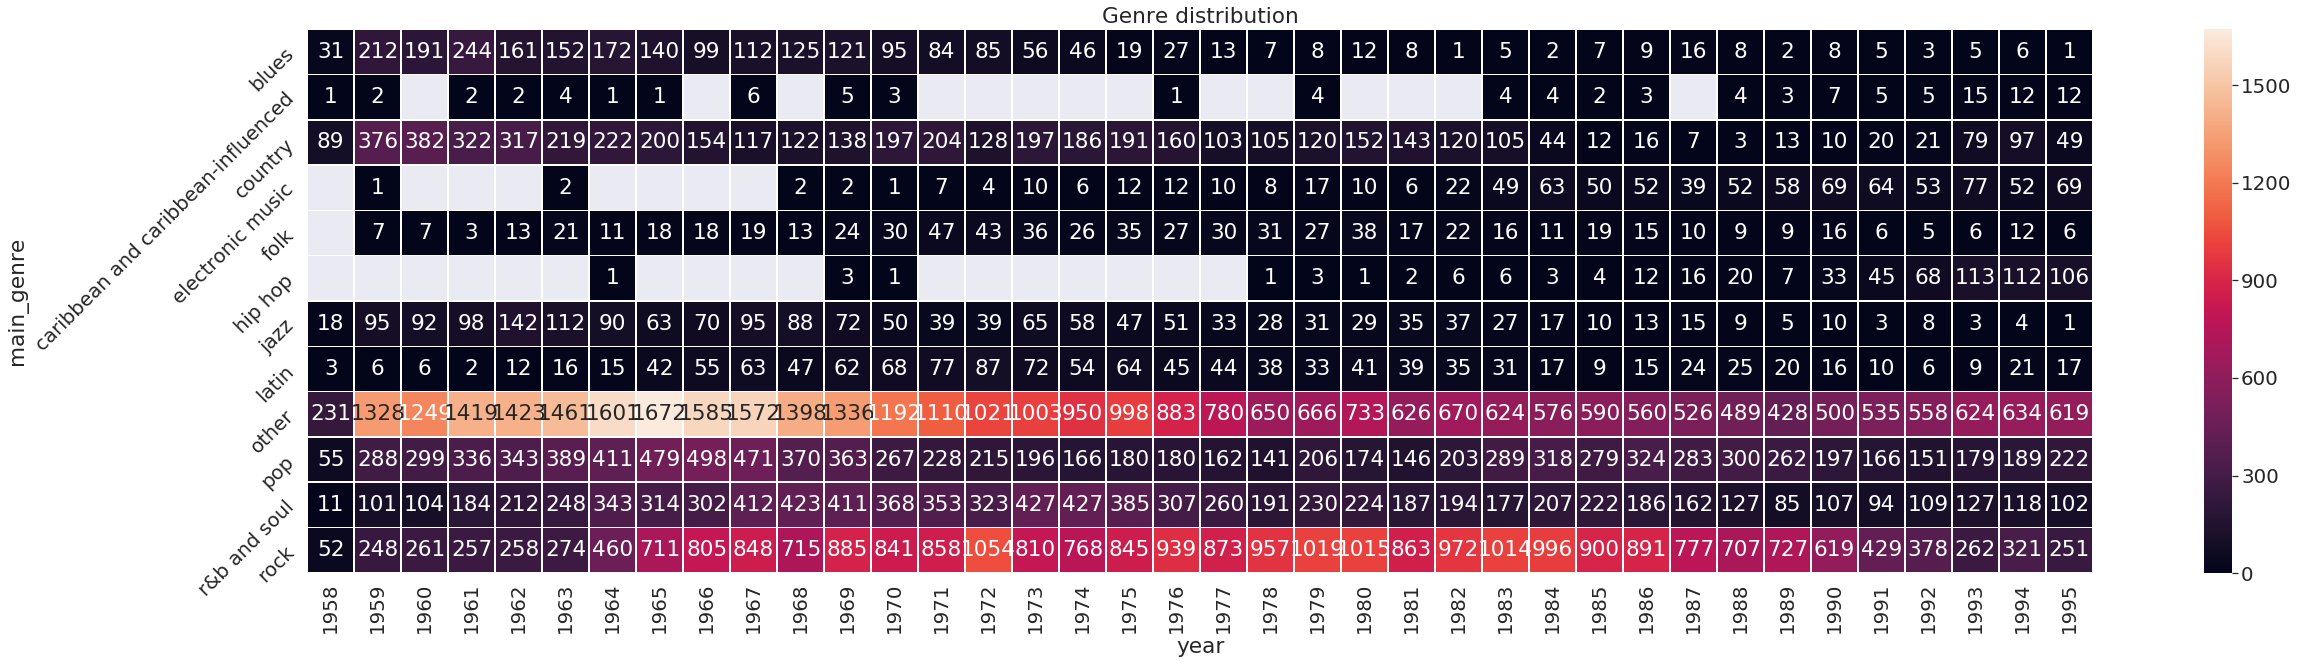

In [62]:
plot_distribution(test, "Genre distribution", "genre_distribution.png")

### Prepare data to plot normalised distribution for each musical genre

In [63]:
#Sum the total of songs given per each musical genre 
each_genre_total = list(test.sum(axis = 1, skipna = True))
test_perc = test.copy()
for column in test_perc: 
    j=0
    for index, row_value in test_perc[column].iteritems():
        test_perc.loc[index, column] = (row_value *100)/each_genre_total[j]
        j+=1

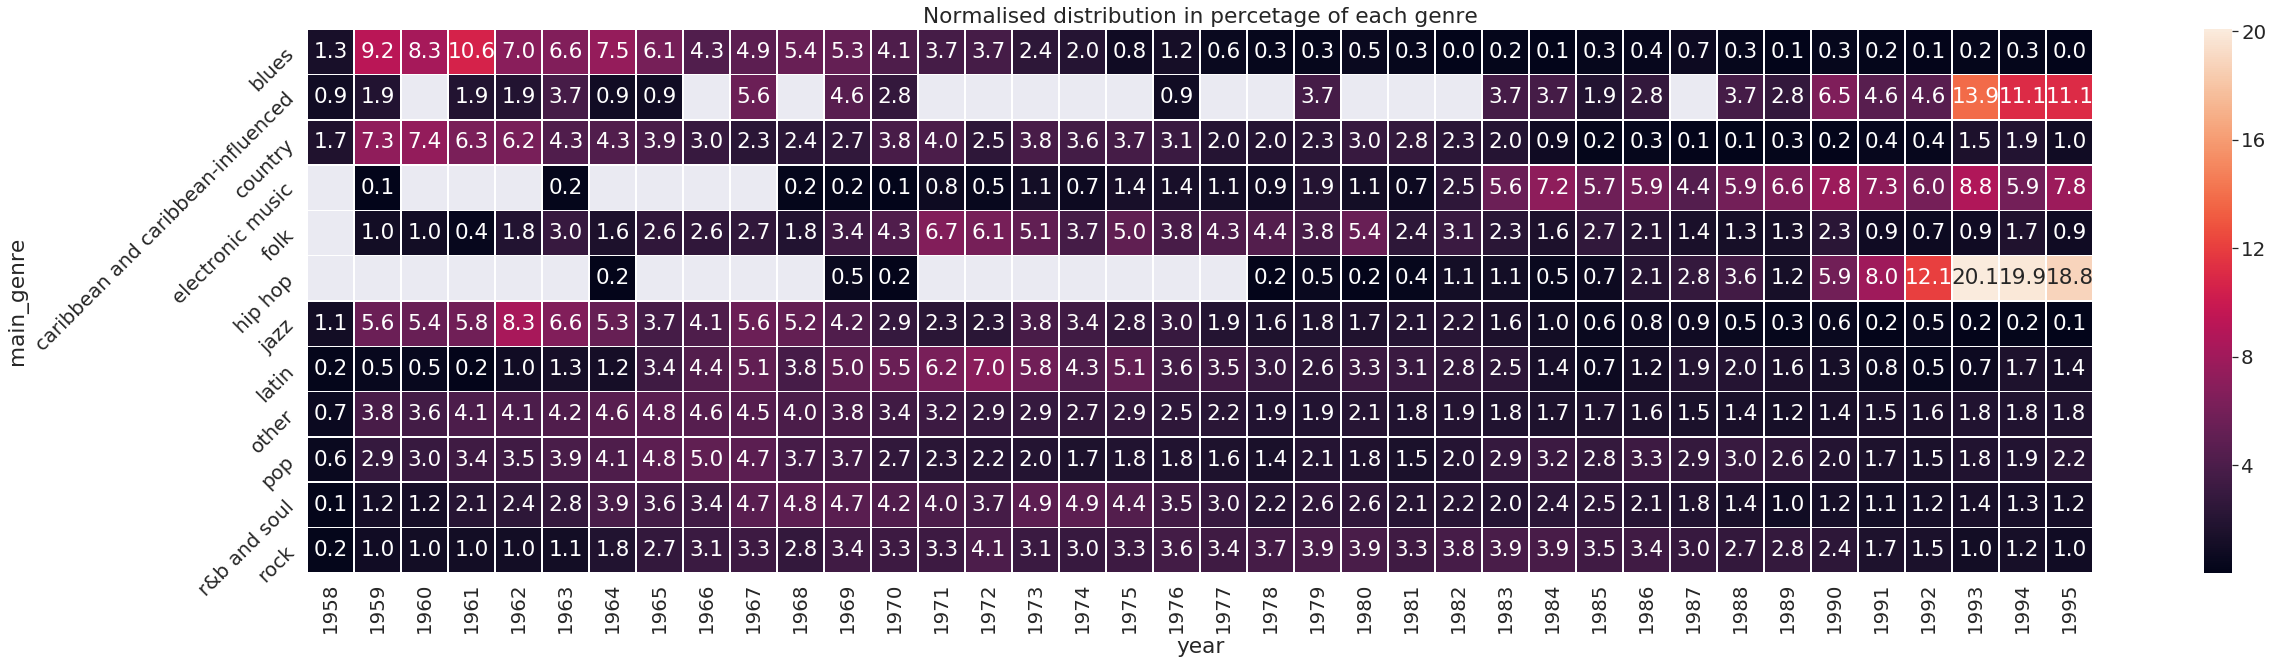

In [65]:
plot_distribution(test_perc, "Normalised distribution in percetage of each genre", "genre_distribution_perc.png", fmt='.1f')

### Prepare data to plot normalized distribution per year

In [66]:
#Sum the total of songs given per each year
each_year_total = list(test.sum(axis = 0, skipna = True))
test_perc_year = test.copy()
j=0
#normalise each cell
for column in test: 
    for index, row_value in test[column].iteritems():
        test_perc_year.loc[index, column] = (row_value *100)/each_year_total[j]
    j+=1

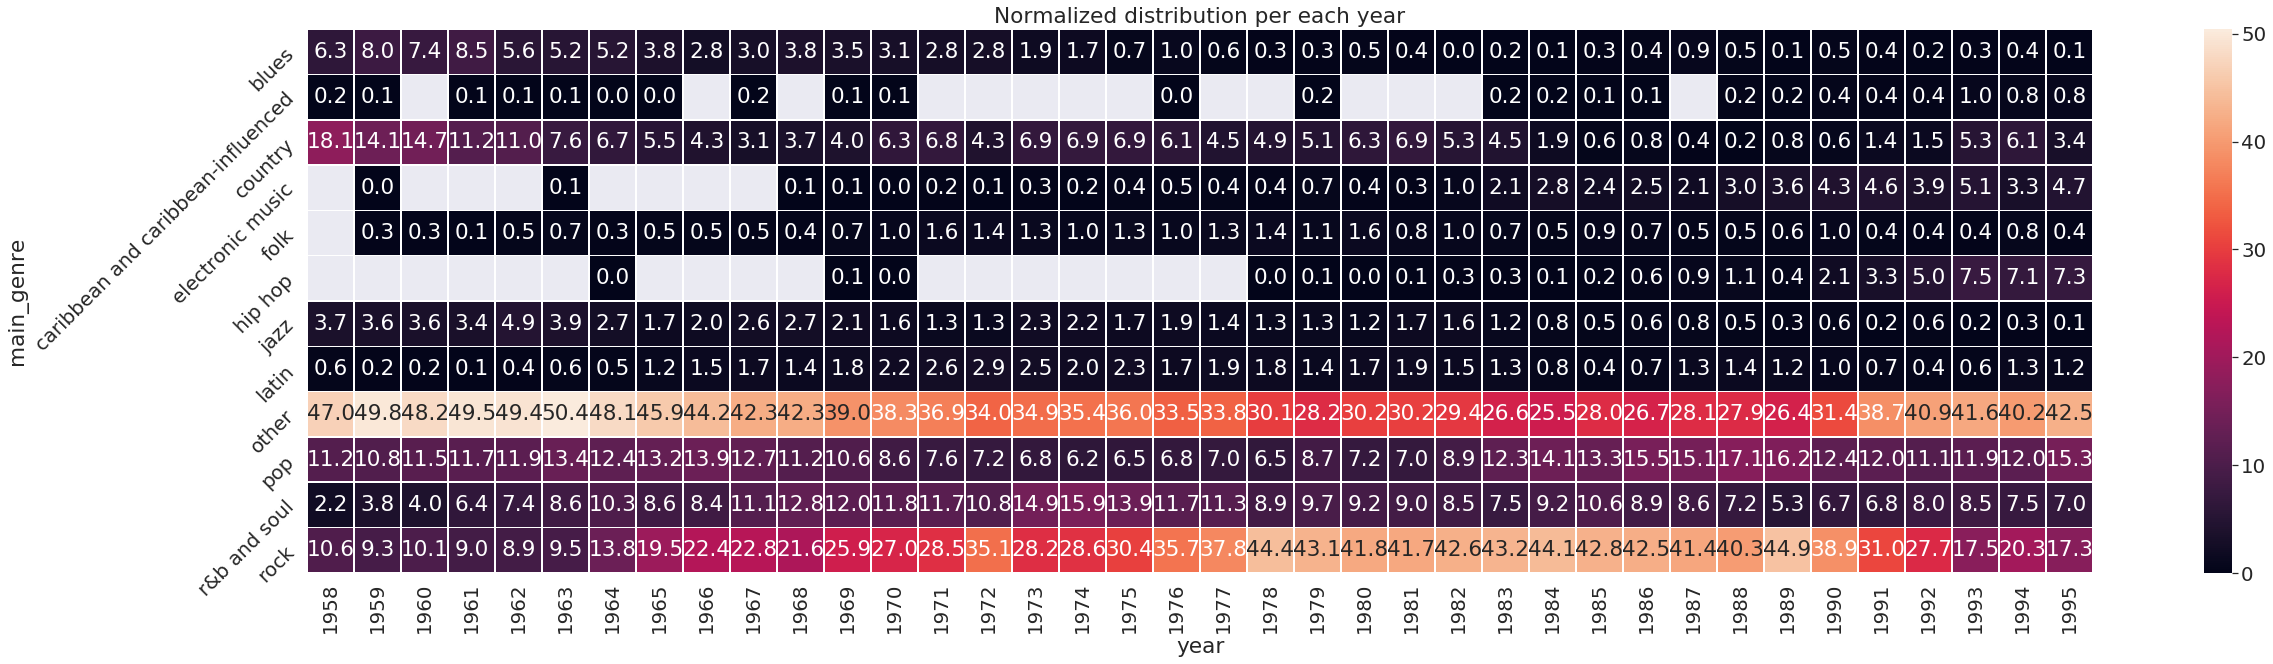

In [67]:
plot_distribution(test_perc_year, "Normalized distribution per each year", "genre_distribution_perc_year.png", fmt='.1f')

### Ploting heatmaps without 'other' category

In [68]:
test_nother = test.drop('other', axis=0)

In [69]:
each_genre_total_nother = list(test_nother.sum(axis = 1, skipna = True))
each_year_total_nother = list(test_nother.sum(axis = 0, skipna = True))

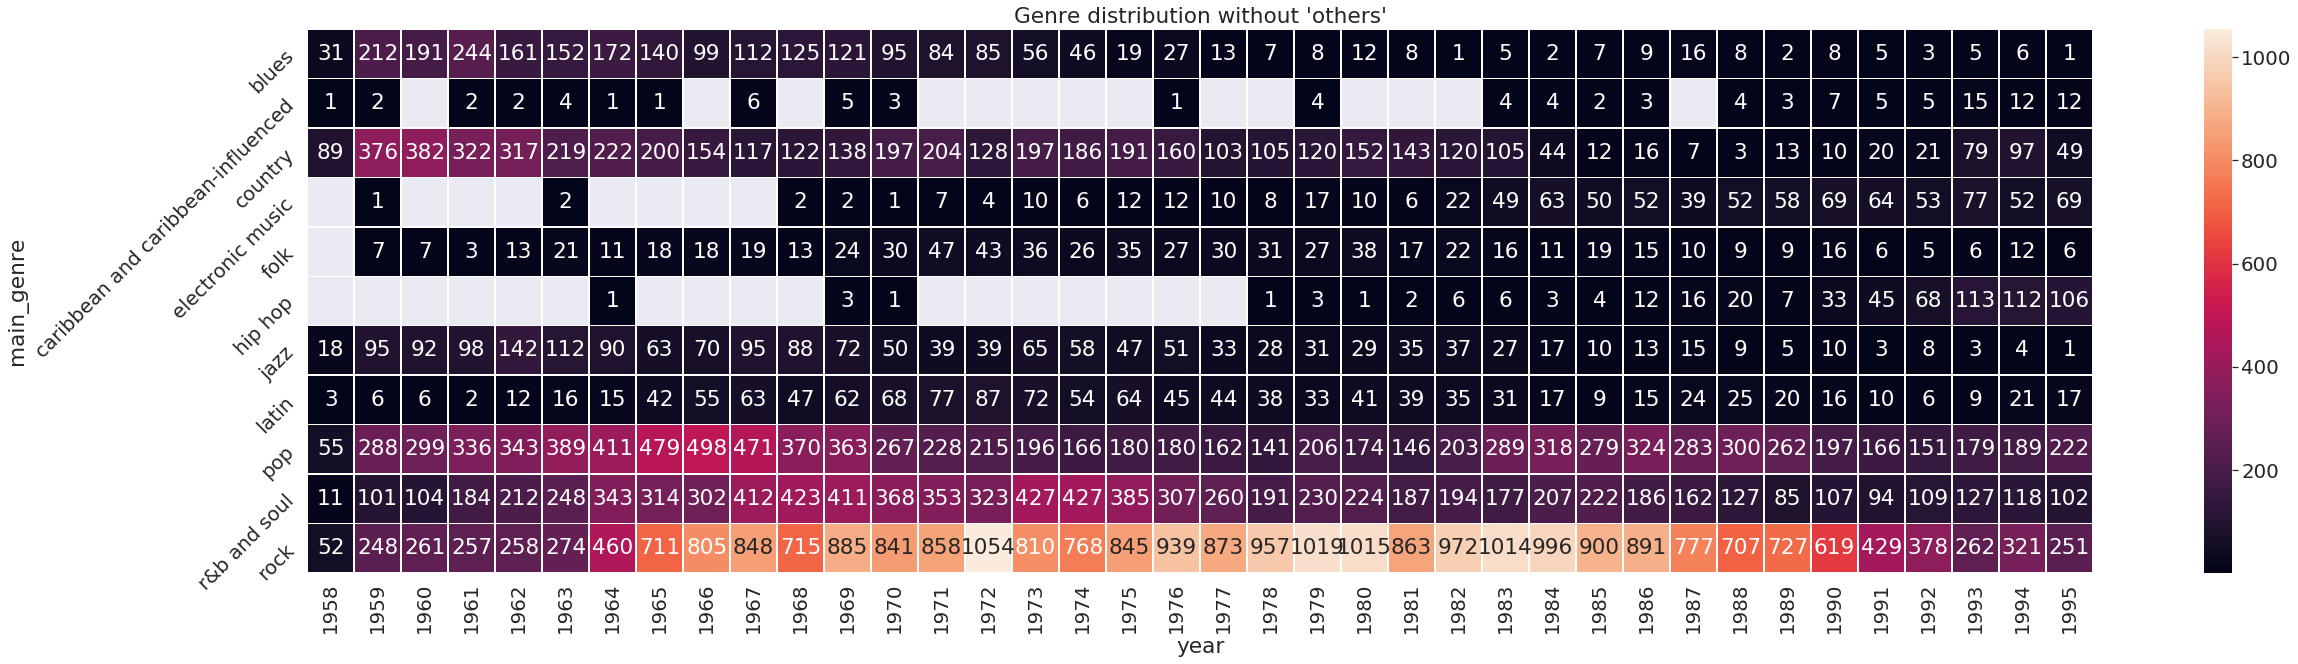

In [70]:
plot_distribution(test_nother, "Genre distribution without 'others'", "genre_distribution_nother.png")

#### Normalized distribution per genre

In [71]:
test_perc_nother = test_nother.copy()
for column in test_perc_nother: 
    j=0
    for index, row_value in test_perc_nother[column].iteritems():
        test_perc_nother.loc[index, column] = (row_value *100)/each_genre_total_nother[j]
        j+=1

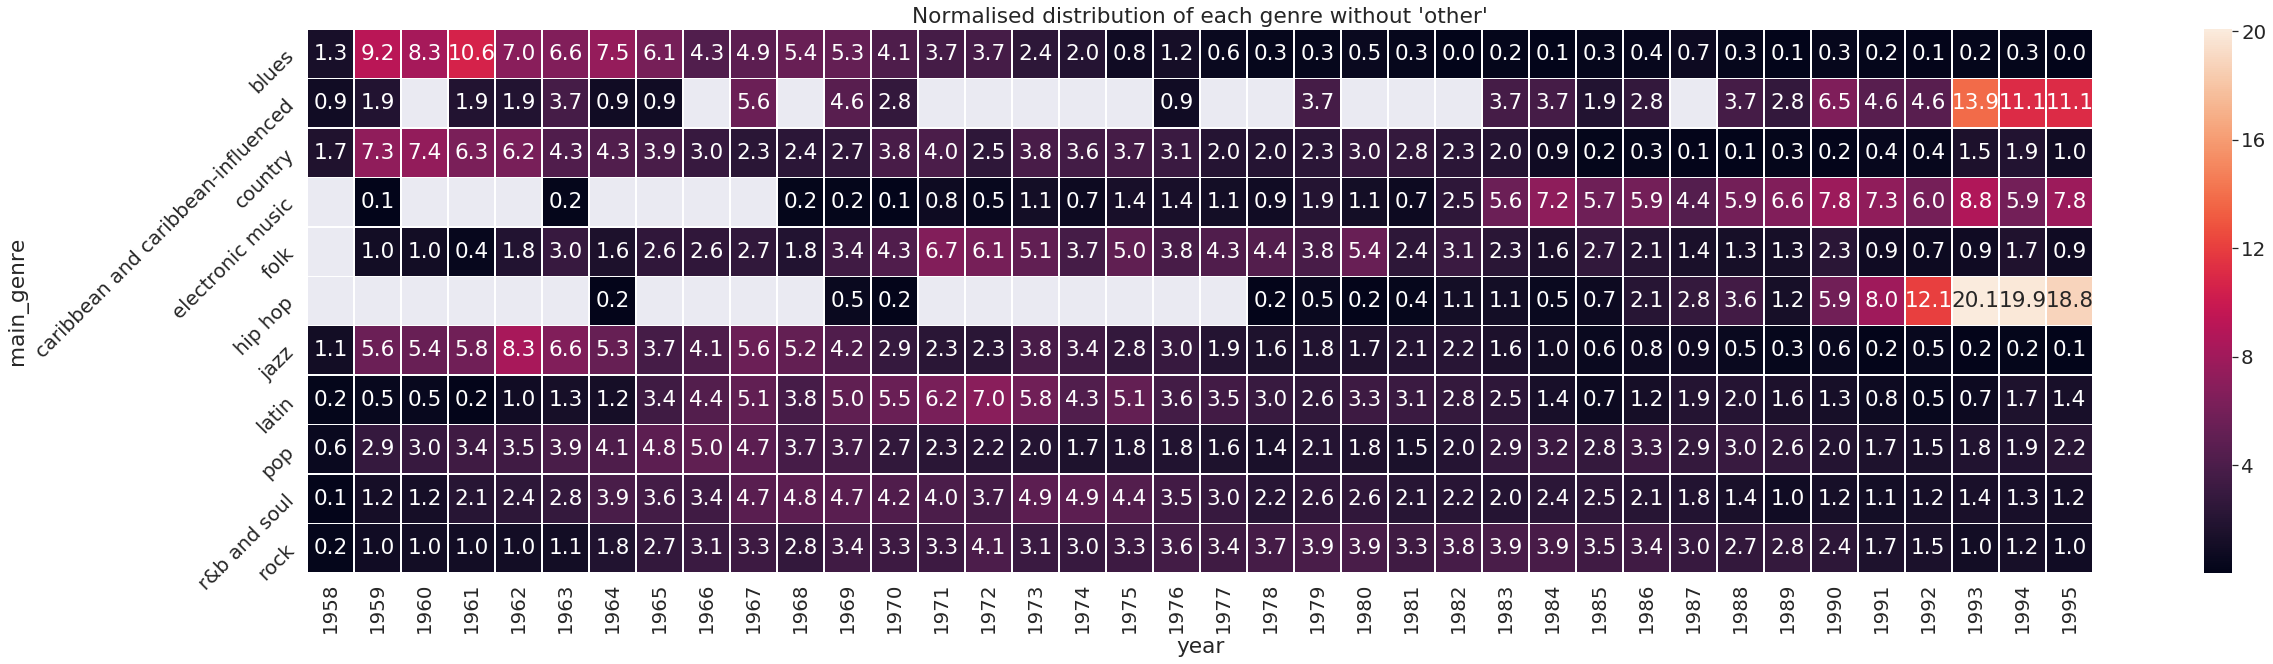

In [72]:
plot_distribution(test_perc_nother, "Normalised distribution of each genre without 'other'", "genre_distribution_perc_nother.png", fmt='.1f')

#### Normalized distribution per year

In [73]:
test_perc_year_nother = test_nother.copy()
j=0
for column in test: 
    for index, row_value in test_nother[column].iteritems():
        test_perc_year_nother.loc[index, column] = (row_value *100)/each_year_total_nother[j]
    j+=1

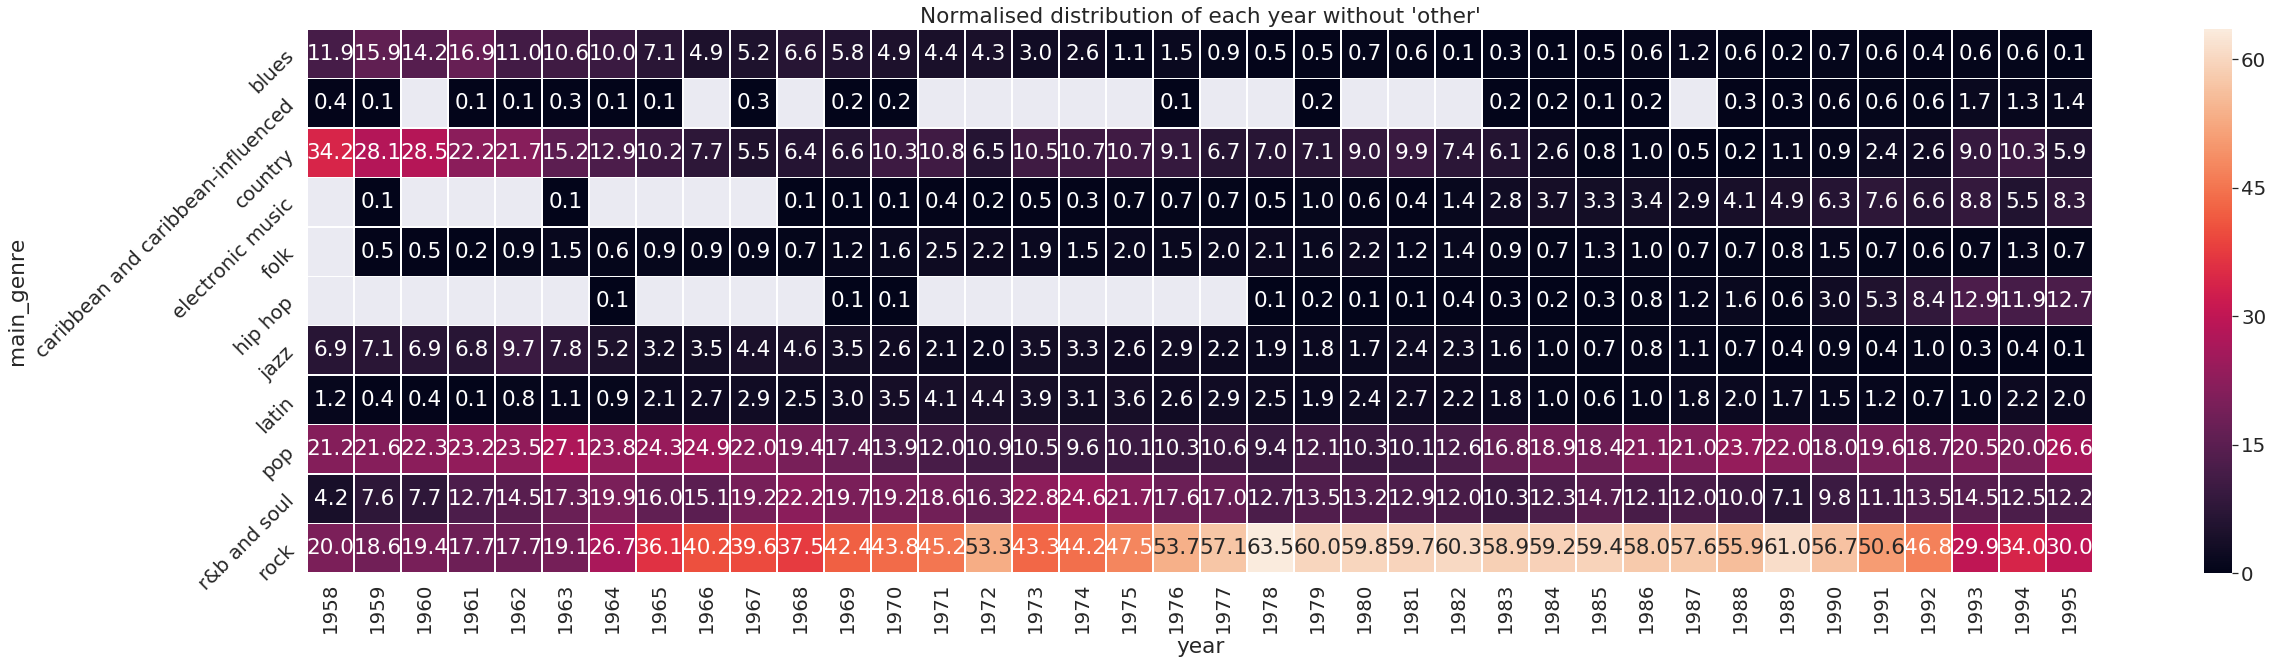

In [74]:
plot_distribution(test_perc_year_nother, "Normalised distribution of each year without 'other'", "genre_distribution_perc_year_nother.png", fmt='.1f')

# Research on time signature

In [2]:
dataset = pd.read_json("json/genre_categories_grouped.json")

In [4]:
dataset.head(2)

,artist_billboard,artist_spotify,duration_ms,energy,genre_list,highest_rank,key,loudness,main_genre,mode,ranks_list,tempo,time_signature,title_billboard,title_spotify,track_id,valence,weeks_list,weeks_on_chart
0,Ricky Nelson,Ricky Nelson,153933,0.332,"[ nashville sound, bubblegum pop, rhythm and...",1,0,-11.573,"[pop, blues, country, other, rock]",1,[1],154.999,4,Poor Little Fool,Poor Little Fool - Remastered,5ayybTSXNwcarDtxQKqvWX,0.795,[1958-08-08],1
100,Chicago,Unknown,-1,-1.000,"[ rock, album rock, mellow gold, soft rock,...",,-1,-1.000,"[other, rock]",-1,"[80, , 66, , 39, , 31, , 20, , 16, ...",-1.000,-1,(i've Been) Searchin' So Long,Unknown,Unknown,-1.000,"[1974-03-15, 1974-03-22, 1974-04-01, 1974-04-0...",27


In [13]:
error_time = dataset.loc[dataset['time_signature']==1]

In [47]:
# Python program to count the frequency of  
# elements in a list using a dictionary 
  
def CountFrequency(my_list): 
  
    # Creating an empty dictionary  
    freq = {} 
    for item in my_list: 
        if (item in freq): 
            freq[item] += 1
        else: 
            freq[item] = 1
            
    newlist= sorted(freq.items(), key=operator.itemgetter(1))
    for key, value in newlist: 
        print ("% s : % d"%(key, value))

In [48]:
CountFrequency(error_time['main_genre'].sum())

hip hop :  1
folk :  3
latin :  4
jazz :  11
country :  12
blues :  13
r&b and soul :  15
pop :  21
rock :  23
other :  60


In [52]:
dataset.loc[dataset['title_billboard']=='We Gotta Get Out Of This Place']

,artist_billboard,artist_spotify,duration_ms,energy,genre_list,highest_rank,key,loudness,main_genre,mode,ranks_list,tempo,time_signature,title_billboard,title_spotify,track_id,valence,weeks_list,weeks_on_chart
61656,The Animals,The Animals,194600,0.61,"[ hard rock, rock, rock-and-roll, folk rock...",,5,-5.276,"[other, rock]",1,"[80, , 68, , 43, , 33, , 26, , 18, ...",124.05,4,We Gotta Get Out Of This Place,We Gotta Get Out Of This Place - UK Single Ver...,5geF5xzPGHxpmk9BDBHphZ,0.45,"[1965-08-08, 1965-08-15, 1965-08-22, 1965-09-0...",21
